In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Leitura dos datasets e rótulos

In [386]:
df = pd.read_csv('../testbed/data/malicious_dataset.csv') # dataset malicioso
attack_classes = pd.read_csv("./data/attack_labels_sbseg.csv") # rótulos dos ataques por ip_src
normal = pd.read_csv('../mawilab/data/normal_dataset.csv') # dataset normal

### Rótulos de ataques

In [387]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn'], dtype=object)

### Criação do dataset malicioso com os rótulos definidos pelo *ip_src*

In [388]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,ip.id,ip.flags,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Dec 31, 1969 21:03:41.953641000 -03",221.953641,20,58,58,0x00000800,4,20,NaN,0x0000b2c5,0x00000000,0,0,0,0,46,6,0x000019e0,172.16.0.3,10.10.10.10,44,0x00000000,62218,8888,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00005cb1,0,1460.0,nmap_tcp_syn
1,1,"Dec 31, 1969 21:03:41.953762000 -03",221.953762,21,58,58,0x00000800,4,20,NaN,0x0000d3a4,0x00000000,0,0,0,0,37,6,0x00000201,172.16.0.3,10.10.10.10,44,0x00000000,62218,587,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00007d1e,0,1460.0,nmap_tcp_syn


In [389]:
normal['label'] = "normal" # criação da coluna label no dataset normal com rótulo "normal"

## Comparação dataset _normal_ e _malicioso_
> Verifica se os dois datasets possuem as mesmas colunas/atributos e calcula o % de dados legítimos e maliciosos

In [390]:
if (df_labeled.columns == normal.columns).all():
    examples_malicious = df_labeled.shape[0]
    examples_legitim = normal.shape[0]
    total = examples_malicious+examples_legitim
    print('Total examples of {0} with {1:0.2f} of malicious and {2:0.2f} legitim packets'.format(total, examples_malicious/total, examples_legitim/total))

Total examples of 125467 with 0.18 of malicious and 0.82 legitim packets


## Pré-processamento
> Necessário conversão dos atributos que são extraídos do `pcap` como hexadecimal
> Preenchido os campos que possuem valores nulos (NaN) por zero

In [391]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))
    

In [392]:
normal = normal.fillna(0)
for field in fields:
    normal[field] = normal[field].apply(lambda x: int(str(x), 16))

### Criação do dataset com todos os pacotes normais e maliciosos

In [393]:
full_data = pd.concat([normal, df_labeled])

### Checando se há pacotes com o campo de protocolo diferente de TCP (valor 6)

In [394]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("Foram encontrados e removidos", wrong_proto,"pacotes do dataset original.")

Foram encontrados e removidos [11708] pacotes do dataset original.


### Atributos não aplicáveis nesse trabalho

> Remoção dos atributos da camada de enlace (link) - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remoção de atributos redudantes ou invariáveis
> - ip.version - trata-se de IPv4
> - ip.proto - o escopo do trabalho restringe-se a TCP
> - ip.src
> - ip.dst
> - ip.flags
> - tcp.flags

In [395]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True) # 'tcp.flags'

## Análise Exploratória dos Dados

In [396]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113759 entries, 1 to 22372
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           113759 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                113759 non-null  int64  
 3   ip.flags.rb          113759 non-null  float64
 4   ip.flags.df          113759 non-null  float64
 5   ip.flags.mf          113759 non-null  float64
 6   ip.frag_offset       113759 non-null  float64
 7   ip.ttl               113759 non-null  float64
 8   ip.checksum          113759 non-null  int64  
 9   ip.len               113759 non-null  float64
 10  ip.dsfield           113759 non-null  int64  
 11  tcp.srcport          113759 non-null  float64
 12  tcp.dstport          113759 non-null  float64
 13  tcp.seq              113759 non-null  float64
 14  tcp.ack              113759 non-null  float64
 15  tcp.len           

In [397]:
full_data.describe()

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.checksum,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val
count,113759.0,91386.0,113759.000000,113759.0,113759.000000,113759.0,113759.0,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,1.137590e+05,1.137590e+05,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,1.137590e+05,113759.000000,113759.000000,100484.000000
mean,20.0,0.0,31347.585993,0.0,0.618316,0.0,0.0,125.907691,32187.994005,629.721332,2.249668,25553.705491,28784.728971,4.012405e+07,4.092436e+07,582.295388,27.425944,0.077137,0.308705,0.022407,0.094683,0.619046,0.035417,0.009608,8.807325e+03,32342.675208,0.766427,198.943693
std,0.0,0.0,19694.286820,0.0,0.485802,0.0,0.0,87.436633,19038.950443,690.759214,8.171465,25107.425855,24827.699185,1.113061e+08,2.439186e+08,688.715939,7.659989,0.266809,0.461961,0.148004,0.292777,0.485624,0.184832,0.097549,7.951332e+04,19024.617715,182.598351,512.382545
min,20.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,1.000000,40.000000,0.000000,21.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,20.0,0.0,13956.000000,0.0,0.000000,0.0,0.0,59.000000,15260.500000,40.000000,0.000000,443.000000,993.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.290000e+02,15978.000000,0.000000,0.000000
50%,20.0,0.0,31071.000000,0.0,1.000000,0.0,0.0,62.000000,31861.000000,64.000000,0.000000,20166.000000,35008.000000,1.000000e+00,1.000000e+00,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.070000e+02,32081.000000,0.000000,0.000000
75%,20.0,0.0,48841.500000,0.0,1.000000,0.0,0.0,242.000000,48728.500000,1426.000000,0.000000,51351.000000,51436.000000,1.367624e+07,4.610000e+03,1374.000000,32.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.200000e+03,48581.500000,0.000000,0.000000
max,20.0,0.0,65535.000000,0.0,1.000000,0.0,0.0,254.000000,65534.000000,5981.000000,224.000000,65534.000000,65535.000000,4.294967e+09,4.294967e+09,5941.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.644544e+07,65533.000000,46335.000000,8961.000000


In [398]:
# checar atributos com variância zero, não contribuem com aprendizado
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset          True
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

In [399]:
# remove colunas com variância zero
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Análise univariada dos atributos (boxplot)

In [400]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

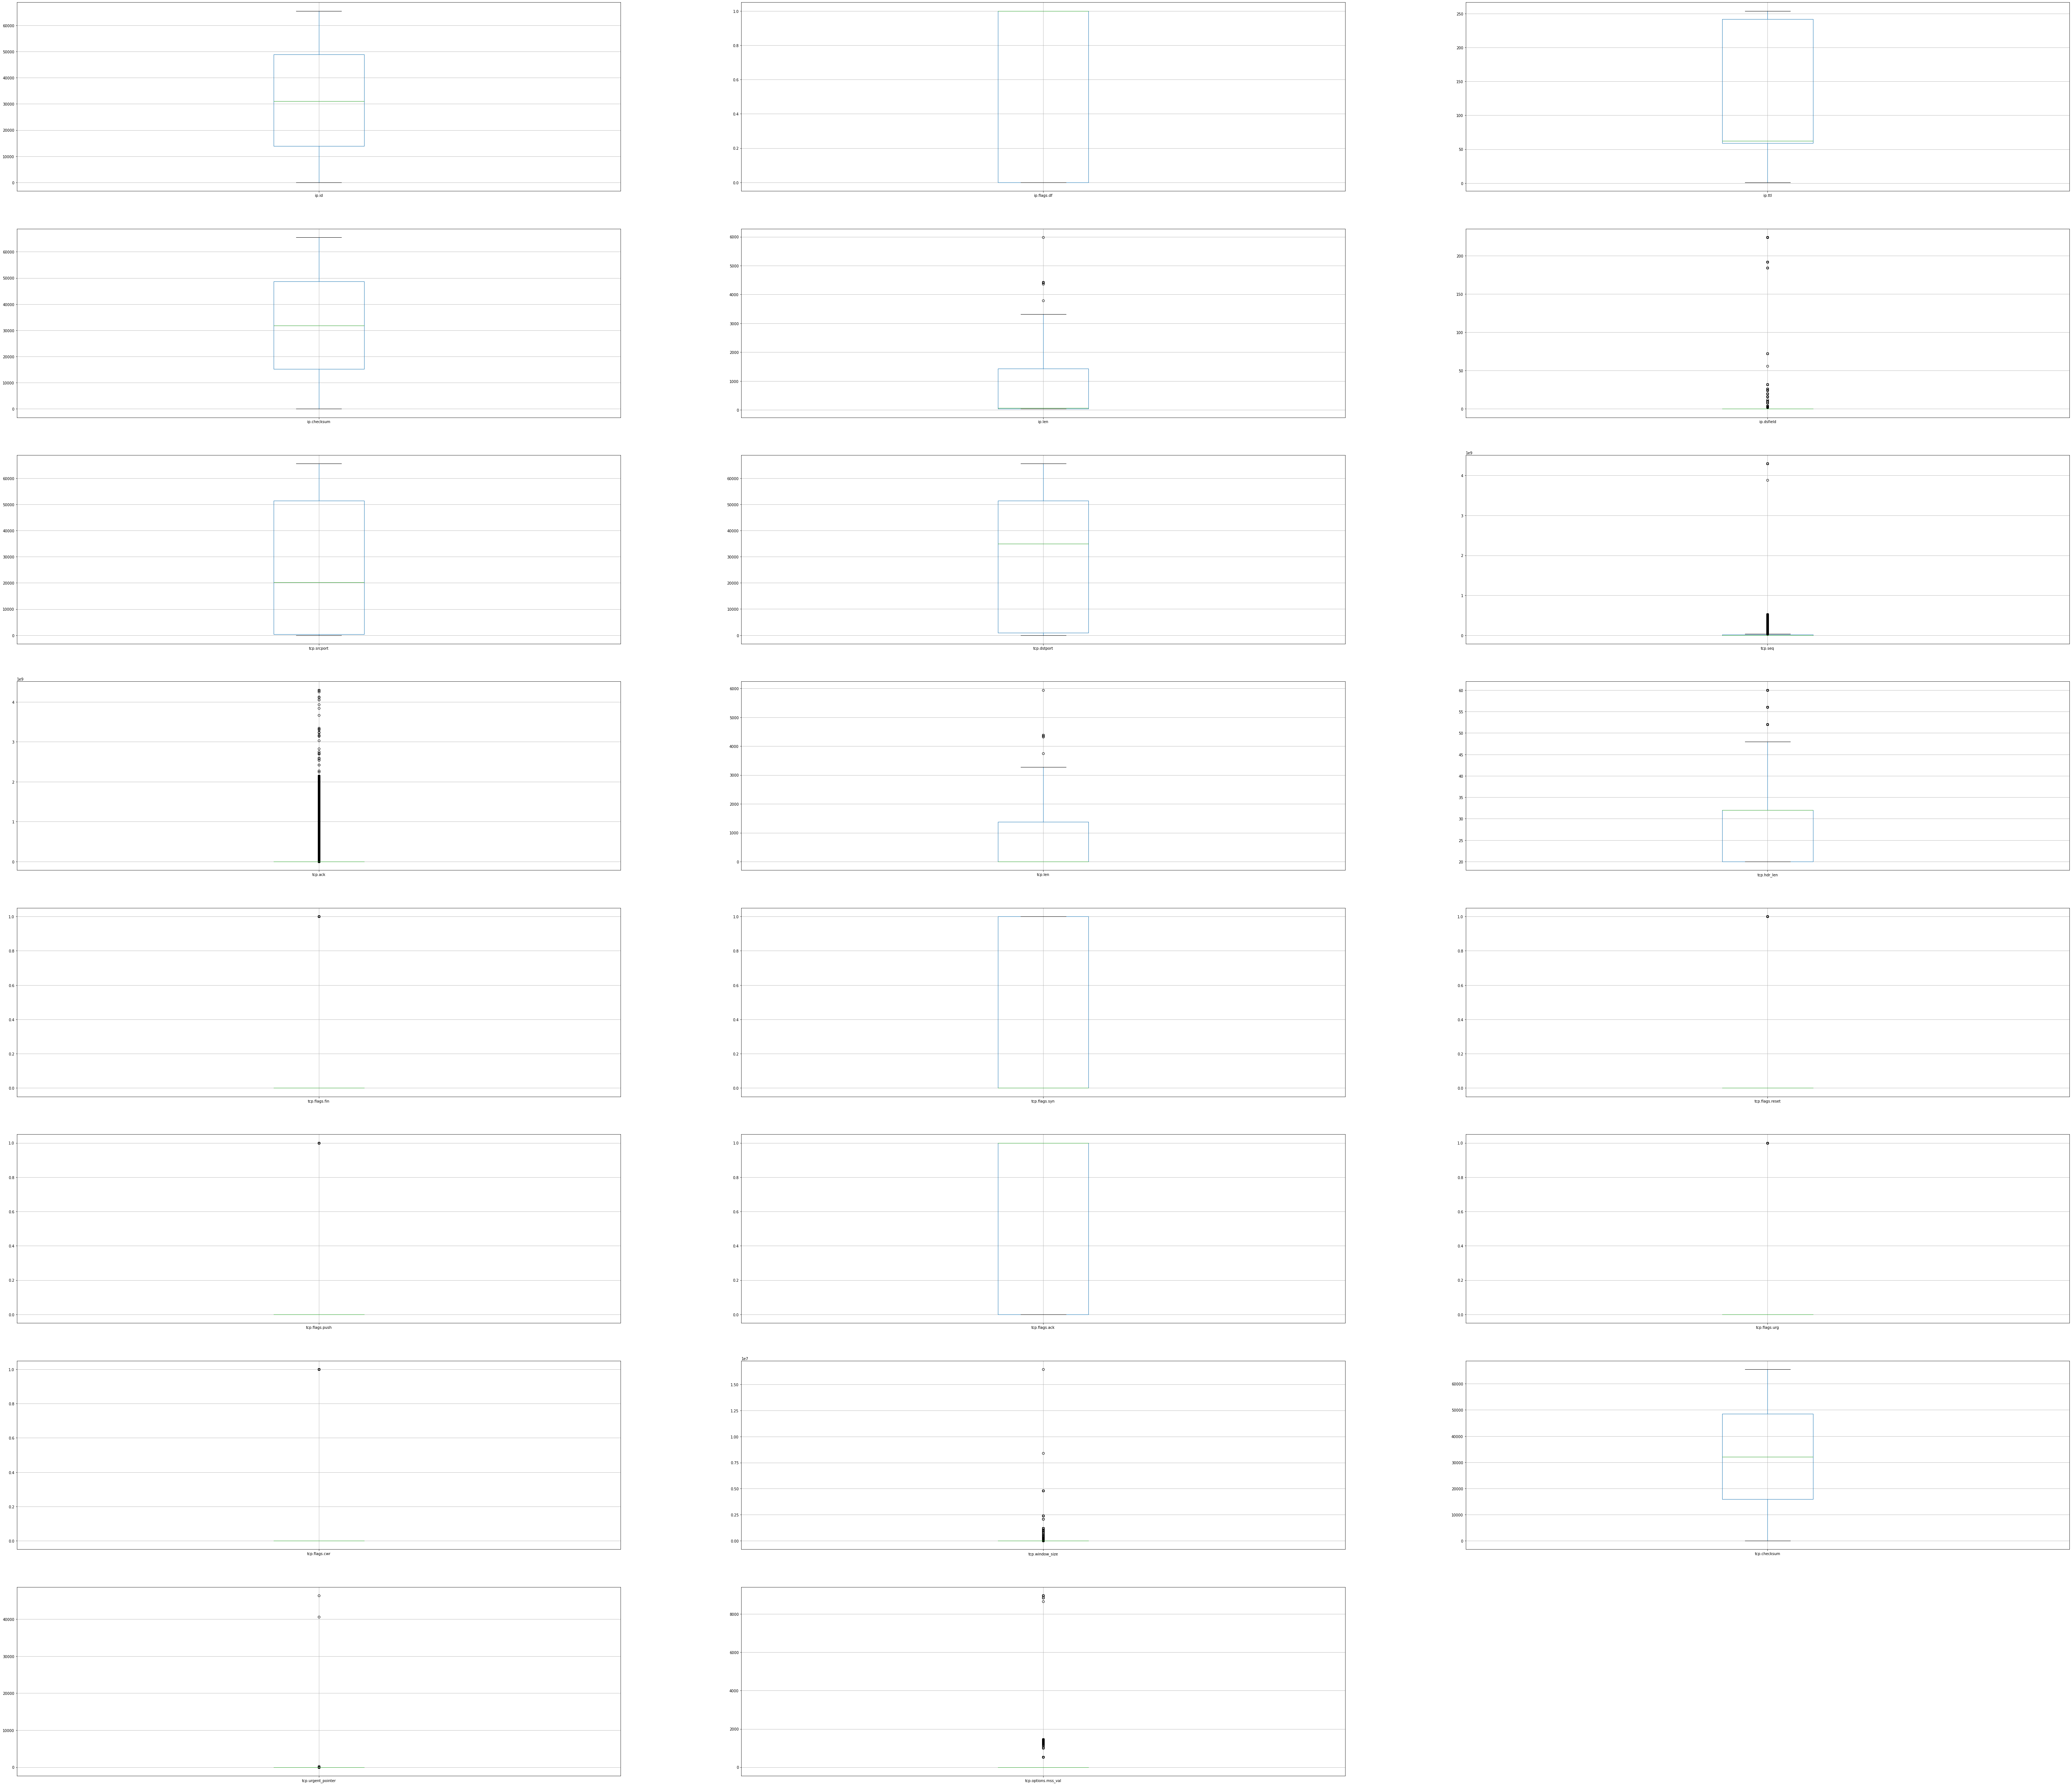

In [401]:
colunas = 3
linhas = int(full_data.shape[1]/colunas)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(linhas, colunas, i)
        full_data.boxplot([column]);
        i += 1

### Análise bivariada - Correlação linear (threshold de 0.5)

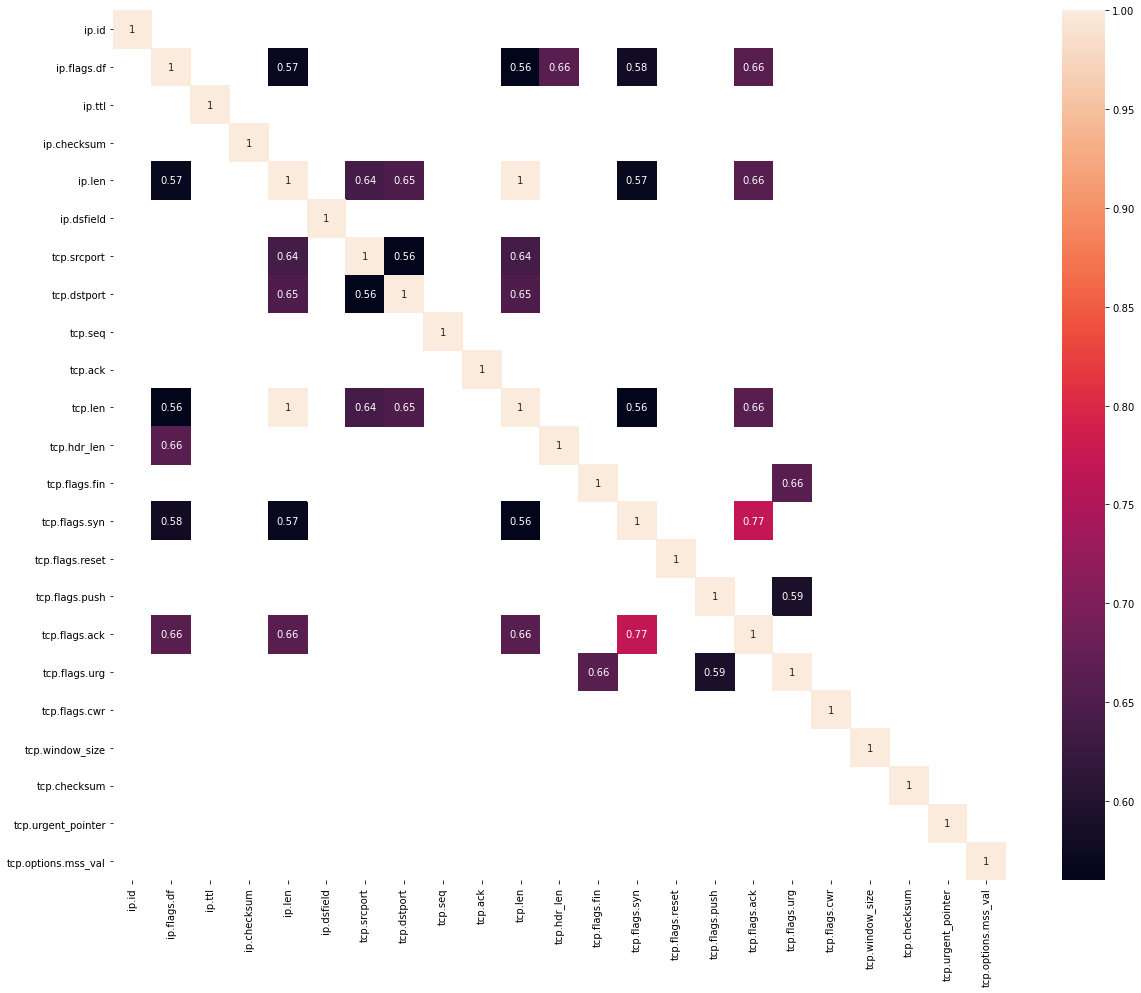

In [402]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Aprendizado de Máquina - Classificação Binária _(scan x normal)_

In [403]:
full_data['label'].value_counts()

normal                   91386
zmap_tcp_syn              1250
unicornscan_tcp_conn      1026
unicornscan_tcp_syn       1017
unicornscan_tcp_null      1014
unicornscan_tcp_fxmas     1014
unicornscan_tcp_fin       1014
unicornscan_tcp_xmas      1014
unicornscan_tcp_ack       1014
masscan_tcp_syn           1003
nmap_tcp_conn             1002
nmap_tcp_syn              1001
nmap_tcp_null             1001
hping_tcp_syn             1001
nmap_tcp_fin              1001
nmap_tcp_xmas             1001
nmap_tcp_ack              1000
hping_tcp_fin             1000
nmap_tcp_window           1000
hping_tcp_xmas            1000
hping_tcp_null            1000
hping_tcp_ack             1000
nmap_tcp_maimon           1000
Name: label, dtype: int64

In [404]:
full_data.label[full_data.label == "normal"] = 0 # converte os labels de normal por 0
full_data.label[full_data.label != 0] = 1 # converte os labels de scan por 1
full_data['label'].value_counts()

0    91386
1    22373
Name: label, dtype: int64

In [405]:
full_data.shape

(113759, 24)

In [406]:
# ttl tem refletido a arquitetura de obtenção dos pacotes TTL=62 (originalmente 64 menos 2 roteadores)
full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val"], axis=1, inplace=True)

In [407]:
full_data

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,label
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22368,32904,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1
22369,55978,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,1
22370,32903,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,1
22371,6985,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1


In [408]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

algorithms = {
    #"MLP" : (MLPClassifier(), {
    #    "hidden_layer_sizes" : (10, 10),
    #}),
    #"XGB" : (XGBClassifier(), {}),
    "NB" : (GaussianNB(), {}),
    "LR" : (LogisticRegression(), {}),
    "RF" : (RandomForestClassifier(random_state=17), {
        "n_estimators" : [10, 50, 100, 200],
        "criterion" : ("gini", "entropy"), 
        "max_depth": [5, 10],
        "class_weight": (None, "balanced", "balanced_subsample")
    }),
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(113759, 15) (113759,)


In [409]:
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0


In [410]:
X = X.astype(int) 
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0,40,0,0,20,0,1,0,0,0,0,0,1024,0
3,3793,1,537,8,485,32,0,0,0,1,1,0,0,252,0
4,0,1,80,0,0,60,0,0,0,0,1,0,0,4677,0
5,8559,1,54,0,2,32,0,0,0,1,1,0,0,115,0
6,54321,0,40,8,0,20,0,1,0,0,0,0,0,65535,0


## Grid Search para os parâmetros da Árvore de Decisão

In [411]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # pode ser considerado também o roc_auc_score na classificação binária

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

NB
LR
RF
DT


In [412]:
# f1-scores para o melhor conjunto de parâmetros do Grid Search
pd.DataFrame.from_dict(score)

,NB,LR,RF,DT
0,0.547546,0.698852,0.956806,0.961631
1,0.542172,0.716488,0.966806,0.967018
2,0.553234,0.689746,0.956844,0.959773
3,0.553465,0.699286,0.957976,0.958187
4,0.548419,0.704593,0.950283,0.960953
5,0.547078,0.702688,0.958315,0.961073
6,0.547747,0.694942,0.957284,0.957932
7,0.549361,0.702334,0.964073,0.964301
8,0.547590,0.681156,0.952859,0.959771
9,0.539101,0.708625,0.953631,0.960141


## Resultado do Grid Search
> Conjunto de hiper-parâmetros, média e desvio padrão

In [346]:
dados = []
for i in range(0,len(best.cv_results_['params'])):
    print(best.cv_results_['params'][i], best.cv_results_['mean_test_score'][i], 
          best.cv_results_['std_test_score'][i])
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])

{'class_weight': None, 'criterion': 'gini', 'max_depth': 1} 0.5159995923854559 0.009914213666751522
{'class_weight': None, 'criterion': 'gini', 'max_depth': 2} 0.6963866804003397 0.004119645468092879
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3} 0.7160002396035535 0.004824867942080026
{'class_weight': None, 'criterion': 'gini', 'max_depth': 4} 0.8117640624351198 0.0021161792932129823
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5} 0.9147693542609483 0.0018993250364913962
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6} 0.9252880966194653 0.0017612853663203246
{'class_weight': None, 'criterion': 'gini', 'max_depth': 7} 0.9391184485384955 0.002487506938279232
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8} 0.9595397259008583 0.0013536768662537012
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9} 0.9604775817192337 0.0010563418353984248
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10} 0.9609915394083489 0.0015191080570

In [347]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

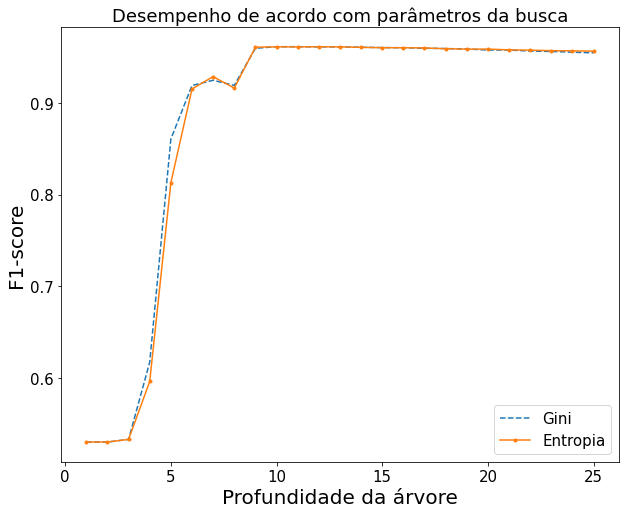

In [348]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 15})

plt.title('Desempenho de acordo com parâmetros da busca')
plt.ylabel('F1-score', fontsize=20)
plt.xlabel('Profundidade da árvore', fontsize=20)
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropia')
plt.legend(loc="lower right");

## Avaliação da importância das features

In [349]:
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

clf = DecisionTreeClassifier(criterion='gini', max_depth=11, class_weight="balanced") # {0: 0.01, 1:0.99}

scores = cross_val_score(clf, X, y, cv=kf, scoring='f1') # recall

print("F1-Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1-Score: 0.961 (+/- 0.01)


In [350]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=11)

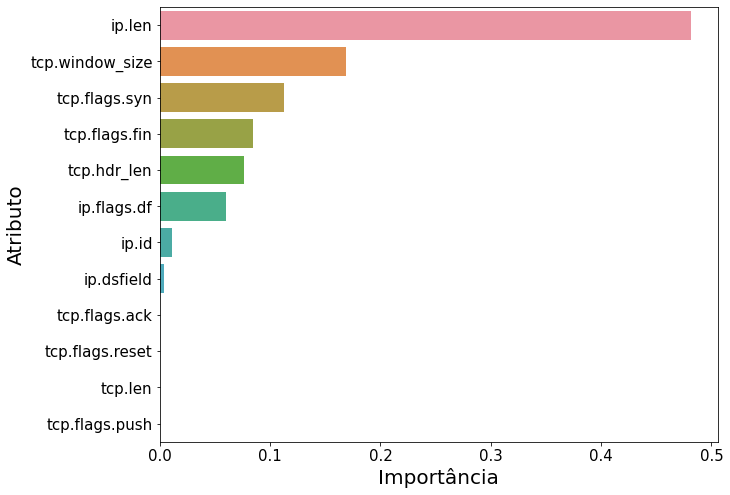

In [351]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(X.columns)

data = {'feature_name': feature_names,
       'feature_importance': feature_importance}

fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

relevantes = fi_df[fi_df.feature_importance > 0]

plt.figure(figsize=(10,8))
sns.barplot(x=relevantes['feature_importance'], y=relevantes['feature_name'])
plt.xlabel('Importância', fontsize=20)
plt.ylabel('Atributo', fontsize=20);

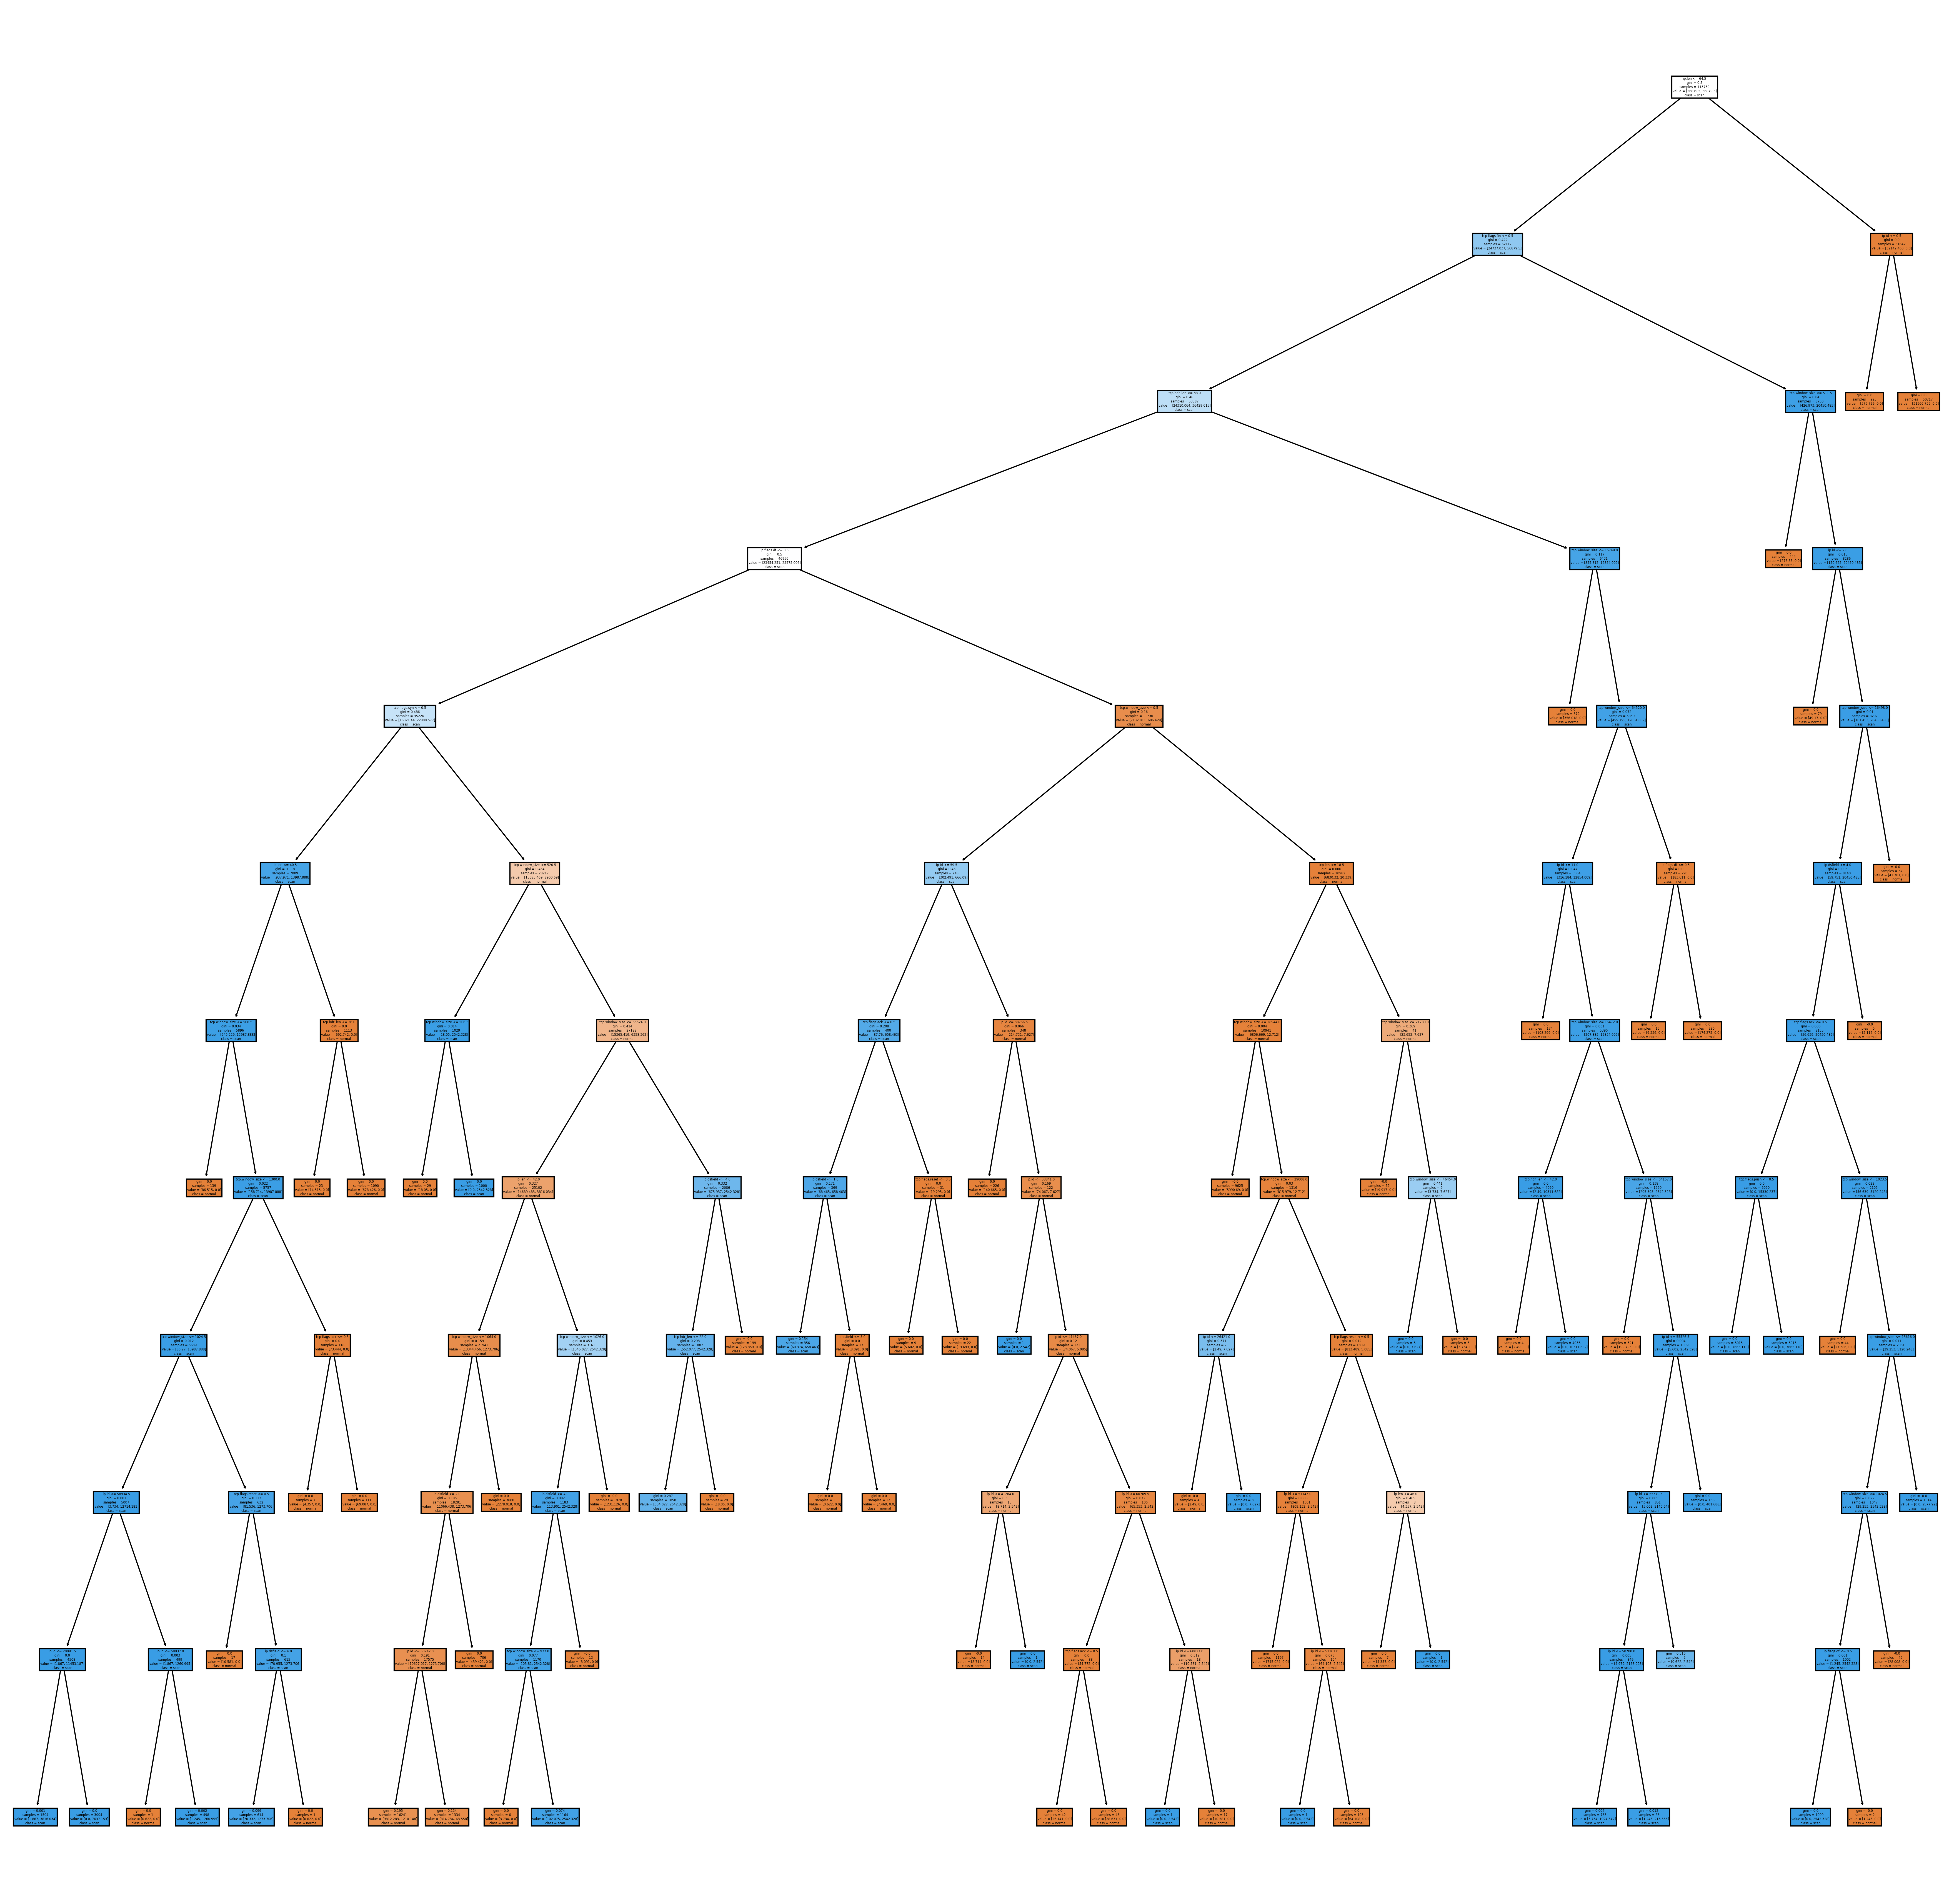

In [352]:
from sklearn import tree

fn=X.columns
cn=['normal', 'scan']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (30,30), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

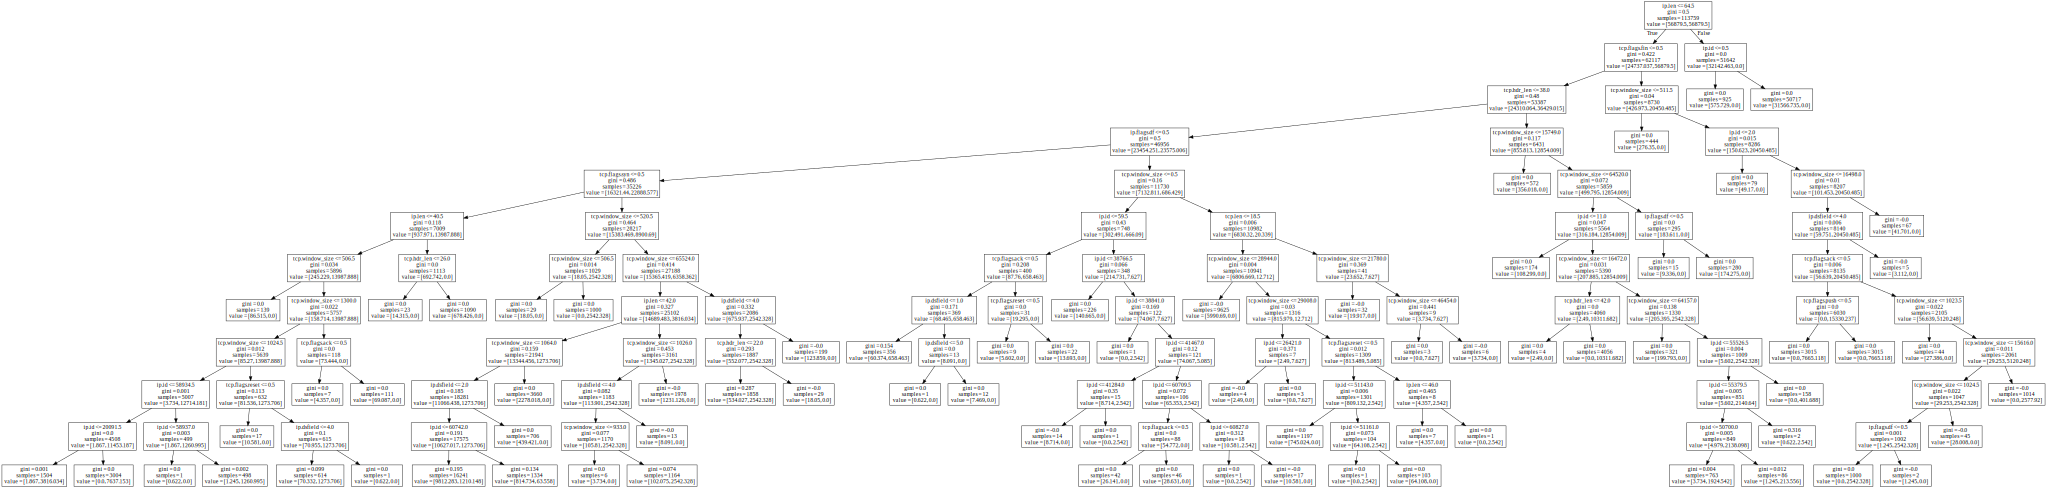

In [353]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(clf, out_file = None, feature_names=X.columns.tolist()))

# Geração do modelo de inferência para ser embarcado

In [354]:
import emlearn
cmodel = emlearn.convert(clf)
cmodel.save(file='./data/scan.h');

In [355]:
X.columns

Index(['ip.id', 'ip.flags.df', 'ip.len', 'ip.dsfield', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.urgent_pointer'],
      dtype='object')